# MCMC5.0: Exact Diagonalization and Thermal Pure Quantum States

To search for the ground state of the physical Hamiltonian, we do not need to diagonalize the Hamiltonian completely. It is enough to find an eigenstate with the lowest energy. Such a partial problem can be solved by iterative methods, and they are implemented in Arpack.jl. This alrogithm may also works for finite temperatures.
*In some cases, Python code works better for this type of problems.*

## Sparse matrix revisited

As seen in MCMC2.5, Julia does not natively support the diagonalization of the sparse matrix, so we need a package called Arpack.jl.

In [1]:
using Arpack

Note that installing Arpack.jl in Julia with Intel MKL takes some efforts.

In [2]:
const A = rand(10, 10)

10×10 Array{Float64,2}:
 0.287038  0.21261    0.930312  0.691452  …  0.271948   0.812221   0.6845  
 0.771168  0.0717781  0.886017  0.229045     0.676093   0.0456913  0.961239
 0.564447  0.394926   0.18119   0.262803     0.221982   0.615819   0.507526
 0.8111    0.995198   0.560008  0.534529     0.611478   0.758001   0.742246
 0.549759  0.719551   0.223031  0.170853     0.11138    0.635207   0.128491
 0.919147  0.518693   0.688814  0.403854  …  0.650306   0.345518   0.958385
 0.299612  0.859857   0.876663  0.750448     0.404751   0.959407   0.865256
 0.66563   0.221044   0.218641  0.123894     0.190349   0.774324   0.571844
 0.886586  0.409243   0.784554  0.333878     0.0908146  0.388625   0.560256
 0.884617  0.0330843  0.895442  0.807219     0.176349   0.630209   0.336853

In [3]:
λ, ϕ = eigs(A, nev = 2)
λ

2-element Array{Complex{Float64},1}:
   5.170394289691692 + 0.0im               
 -0.5131333628179474 + 0.7157980017849478im

In [4]:
using LinearAlgebra
eigvals(A)

10-element Array{Complex{Float64},1}:
    5.170394289691707 + 0.0im                
  -0.5131333628179472 + 0.7157980017849478im 
  -0.5131333628179472 - 0.7157980017849478im 
  0.45341578096903024 + 0.29471051502132883im
  0.45341578096903024 - 0.29471051502132883im
 -0.16378971416721885 + 0.3464195674927234im 
 -0.16378971416721885 - 0.3464195674927234im 
  -0.6321953680128054 + 0.0im                
 -0.48368784443415663 + 0.0im                
  0.13047139395916513 + 0.0im                

It is clear that `eigs` takes 2 of the whole eigenvalues approximately (almost exactly). Such iterative methods in Arpack.jl is important in the case we do not need every spectrum.

More importantly, Arpack.jl supports sparse matrices (and even abstract `LinearMaps`), so the diagonalization of sparse matrices becomes very fast.

In [6]:
using SparseArrays
B = sparse(rand(1 : 1000, 20000), rand(1 : 1000, 20000), rand(20000))
B

1000×1000 SparseMatrixCSC{Float64,Int64} with 19808 stored entries:
  [24  ,    1]  =  0.534776
  [81  ,    1]  =  0.676702
  [129 ,    1]  =  0.0833842
  [269 ,    1]  =  0.751787
  [285 ,    1]  =  0.0236976
  [334 ,    1]  =  0.842954
  [341 ,    1]  =  0.0337986
  [350 ,    1]  =  0.781292
  [433 ,    1]  =  0.0484997
  [468 ,    1]  =  0.704006
  [487 ,    1]  =  0.10838
  [592 ,    1]  =  0.43524
  ⋮
  [357 , 1000]  =  0.815957
  [364 , 1000]  =  0.887257
  [546 , 1000]  =  0.780161
  [548 , 1000]  =  0.0708445
  [564 , 1000]  =  0.92033
  [644 , 1000]  =  0.606127
  [680 , 1000]  =  0.884121
  [704 , 1000]  =  0.227908
  [741 , 1000]  =  0.115991
  [789 , 1000]  =  0.0716153
  [876 , 1000]  =  0.518255
  [903 , 1000]  =  0.708294

In [7]:
λ, ϕ = eigs(B, nev = 1)
λ

1-element Array{Complex{Float64},1}:
 10.002515149187186 + 0.0im

In [8]:
eigvals(Array(B))

1000-element Array{Complex{Float64},1}:
    10.002515149187175 + 0.0im                 
   -0.2813804641690999 + 2.618304187248648im   
   -0.2813804641690999 - 2.618304187248648im   
    -2.600831267690369 + 0.344546652801247im   
    -2.600831267690369 - 0.344546652801247im   
     -2.33458850450441 + 1.133923936459642im   
     -2.33458850450441 - 1.133923936459642im   
    -2.193502166524338 + 1.3454110888489037im  
    -2.193502166524338 - 1.3454110888489037im  
   -1.5601742500825693 + 2.0719667389709033im  
   -1.5601742500825693 - 2.0719667389709033im  
   -1.9391675530568744 + 1.6802511956546602im  
   -1.9391675530568744 - 1.6802511956546602im  
                       ⋮                       
   0.24650982103143915 - 0.07281169299355386im 
  -0.21183310736409416 + 0.19584251889928306im 
  -0.21183310736409416 - 0.19584251889928306im 
   0.24729459839031118 + 0.0im                 
  -0.00686048319340303 + 0.1815441274472194im  
  -0.00686048319340303 - 0.1815441274472194im  


If you only need a few eigenvalues and eigenstates, `eigs` is much faster.

## Exact diagonalization of many-body Hamiltonians

In [9]:
function openhoneycomb(Lx::Int64, Ly::Int64)::Tuple
    N = 2Lx * Ly
    nnx = zip(1 : 2 : (N - 1), 2 : 2 : N)
    nny = Iterators.flatten((zip((1 + 2i) : 2Lx : (2Lx * (Ly - 1)  + 1 + 2i), 2i : 2Lx : (2Lx * (Ly - 1)  + 2i)) for i in 1 : (Lx - 1)))
    nnz = zip(1 : 2 : (N - 1), Iterators.flatten(((2Lx + 2) : 2 : N, 2 : 2 : 2Lx)))
    N, nnx, nny, nnz
end

openhoneycomb (generic function with 1 method)

In [10]:
const σx = sparse(Complex{Float64}[0.0 1.0; 1.0 0.0])
const σy = sparse(Complex{Float64}[0.0 -1.0im; 1.0im 0.0])
const σz = sparse(Complex{Float64}[1.0 0.0; 0.0 -1.0])

2×2 SparseMatrixCSC{Complex{Float64},Int64} with 2 stored entries:
  [1, 1]  =  1.0+0.0im
  [2, 2]  =  -1.0+0.0im

$ I_1 \otimes I_2 \otimes \dots \otimes \sigma_i \otimes \dots \otimes I_{N-1} \otimes I_N$

In [11]:
"""
Returning Pauli operators at ith site

σ must be a Pauli matrix
"""
function spinoperators(σ::SparseMatrixCSC{Complex{Float64},Int64}, i::Int64, N::Int64)::SparseMatrixCSC{Complex{Float64},Int64}
    if N < 1
        throw(DomainError(N, "argument must be positive"))
    elseif i == 1 && N == 1
        σ
    elseif N == 1
        sparse(I, 2, 2)
    elseif i == N
        kron(spinoperators(σ, i, N - 1), σ)
    else
        kron(spinoperators(σ, i, N - 1), sparse(I, 2, 2))
    end
end
Array(spinoperators(σx, 2, 2))

4×4 Array{Complex{Float64},2}:
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  1.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im

This is a slow recursive code, but it does not matter for our purpose. Actually, in this case, two Kronecker products are enough.

**Exercise1**: Rewrite `spinoperators` not using a loop or recursion.

In [12]:
N, nnx, nny, nnz = openhoneycomb(2, 2)
σi = map(x -> spinoperators(x..., N), Iterators.product([σx, σy, σz], 1 : N));

Now a many-body Hamiltonian can be constructed simply.

In [13]:
const Jx = 1 / 3
const Jy = 1 / 3
const Jz = 1 / 3
H = spzeros(Complex{Float64}, 1 << N, 1 << N)
for (J, nn, σ) in zip([Jx, Jy, Jz], [nnx, nny, nnz], [σi[1, :], σi[2, :], σi[3, :]])
    σlist = collect(σ)
    for bond in nn
        H += J * σlist[bond[1]] * σlist[bond[2]]
    end
end
H

256×256 SparseMatrixCSC{Complex{Float64},Int64} with 1696 stored entries:
  [1  ,   1]  =  1.33333+0.0im
  [4  ,   1]  =  0.333333+0.0im
  [7  ,   1]  =  -0.333333+0.0im
  [13 ,   1]  =  0.333333+0.0im
  [49 ,   1]  =  0.333333+0.0im
  [97 ,   1]  =  -0.333333+0.0im
  [193,   1]  =  0.333333+0.0im
  [2  ,   2]  =  0.666667+0.0im
  [3  ,   2]  =  0.333333+0.0im
  [8  ,   2]  =  -0.333333+0.0im
  [14 ,   2]  =  0.333333+0.0im
  [50 ,   2]  =  0.333333+0.0im
  ⋮
  [207, 255]  =  0.333333+0.0im
  [243, 255]  =  0.333333+0.0im
  [249, 255]  =  -0.333333+0.0im
  [254, 255]  =  0.333333+0.0im
  [255, 255]  =  0.666667+0.0im
  [64 , 256]  =  0.333333+0.0im
  [160, 256]  =  -0.333333+0.0im
  [208, 256]  =  0.333333+0.0im
  [244, 256]  =  0.333333+0.0im
  [250, 256]  =  -0.333333+0.0im
  [253, 256]  =  0.333333+0.0im
  [256, 256]  =  1.33333+0.0im

In [14]:
E, ψ = eigs(H, nev = 200, which = :SR, tol=1e-4, ritzvec=false, maxiter=500)
Esorted = sort(real.(E), rev=true)

200-element Array{Float64,1}:
  0.963664152868519 
  0.9636641528685188
  0.9636641528685186
  0.9636641528685178
  0.6666666666666725
  0.6666666666666713
  0.6666666666666708
  0.66666666666667  
  0.6666666666666696
  0.6666666666666694
  0.6666666666666693
  0.6666666666666683
  0.6666666666666681
  ⋮                 
 -1.7632326996322496
 -1.7632326996322505
 -1.7632326996322507
 -1.763232699632253 
 -1.7632326996322556
 -1.7632326996322563
 -1.763232699632257 
 -1.7632326996322605
 -1.9999999999999973
 -1.9999999999999996
 -1.9999999999999996
 -2.000000000000009 

In order to plot the heat capacity curve, probably it is enough to use the 200 lowest energy states at low temperature. Note that 200 is a multiple of 4.

In [15]:
Z(E::Vector{Float64}) = β::Float64 -> sum(@. exp(-β * E))
intE(E::Vector{Float64}) = β::Float64 -> sum(@. E * exp(-β * E)) / Z(E)(β)
intE²(E::Vector{Float64}) = β::Float64 -> sum(@. (E ^ 2) * exp(-β * E)) / Z(E)(β)
Cv(E::Vector{Float64}) = β::Float64 -> β ^ 2 * (intE²(E)(β) - intE(E)(β) ^ 2)
Cv(Esorted)(10.0)

1.4791528702474466

For this problem (N = 8), it is ok to use `eigvals`, but if N > 12, it is already difficult to use `eigvals`.

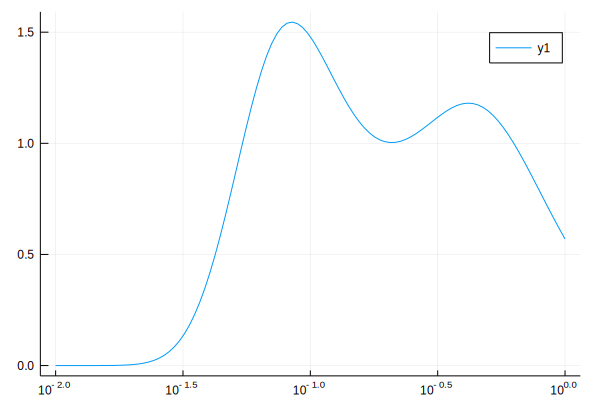

In [16]:
using Plots; gr()
βs = exp.(log(10) * collect(range(0.0, stop = 2.0, length = 100)))
plot(1 ./ βs, map(Cv(Esorted), βs); xscale = :log10)

The difference from the original paper comes from the difference in the boundary conditions.

**Exercise2**: try to do the same approximation in Kitaev model QMC, and check whether it is efficient or not.

## Thermal pure quantum (TPQ) state

If you wish to plot the heat capacity for a large system, it is recommended to use TPQ states instead of the exact diagonalization. Currently, the easiest way to use TPQ states is to install HPhi: https://github.com/issp-center-dev/HPhi.

However, I will show a simple implementation of the calculation of TPQ states. The calculation of TPQ states is very much realated to exact diagonalization because they are both using Krylov subspace methods and TPQ states are calculated by almost the same computational cost as that for the ground state. Both calculations use the sparsity of the Hamiltonian intensively.

### microcanonical TPQ (mTPQ) state

In [17]:
const l = 1.0
const D = 1 << N

256

$l$ is an arbitrary number which has to be greater than the largest eigenvalue of $H / N$.

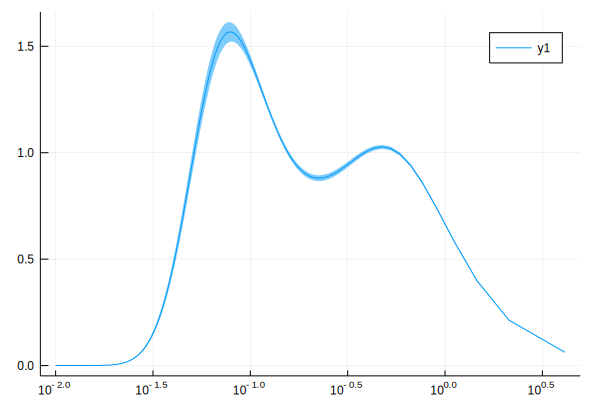

In [18]:
using ResumableFunctions
using Statistics
braket(bra::AbstractVector{T}, ket::AbstractVector{T}) where T = bra' * ket
@resumable function mTPQ(H::AbstractMatrix, ℓ::Float64, N::Int64, D::Int64)::Float64
    Nstep = 500
    Φtemp = exp.(2.0im * π * rand(D)) .* sqrt.(-log.(rand(D))) # This is Box-Muller
    # Φtemp = rand([1.0, -1.0], D)
    Φ = Φtemp / norm(Φtemp)
    for k in 1 : Nstep
        Φtemp = (ℓ * I - H / N) * Φ
        Φ = Φtemp / norm(Φtemp)
        E = braket(Φ, H * Φ)
        β = 2k / N / (ℓ - E / N)
        HΦ = H * Φ
        E² = braket(HΦ, HΦ)
        @yield real(β)
        @yield real(E² - E * E)
    end
end
Nsample = 100
data = [collect(mTPQ(H, l, N, D)) for i in 1 : Nsample] # This is not a good code
m = mean(data)
s = stdm(data, m) / sqrt(Nsample)
cv = collect(Iterators.partition(m, 2))
eb = collect(Iterators.partition(s, 2)) # the errorbar for β is almost negligible
plot(map(x -> 1 / x[1], cv), map(x -> x[1] ^ 2 * x[2], cv), ribbon = map(x -> x[1][1] ^ 2 * x[2][2], zip(cv, eb)); xscale = :log10)

## Comparison between QMC and ED/TPQ

As for TPQ, it is accurate enough if we take 1000 draws for the initial vector. Let's compare QMC, TPQ and full ED.

### Full ED

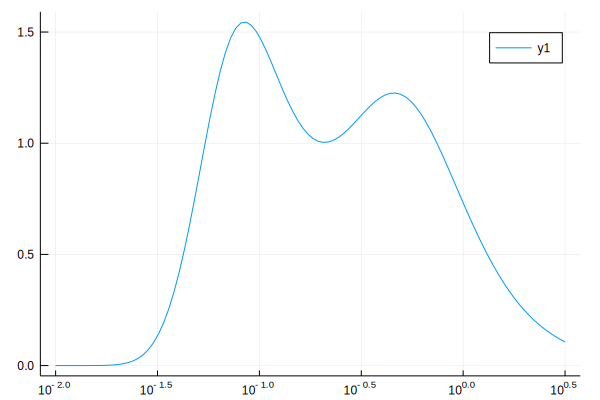

In [19]:
Efull = eigvals(Hermitian(Array(H)))
Efullsorted = sort(Efull, rev=true)
βs = exp.(log(10) * collect(range(-0.5, stop = 2.0, length = 100)))
plot(1 ./ βs, map(Cv(Efullsorted), βs); xscale = :log10)

For this very small system full ED is actually fast enough!

### mTPQ

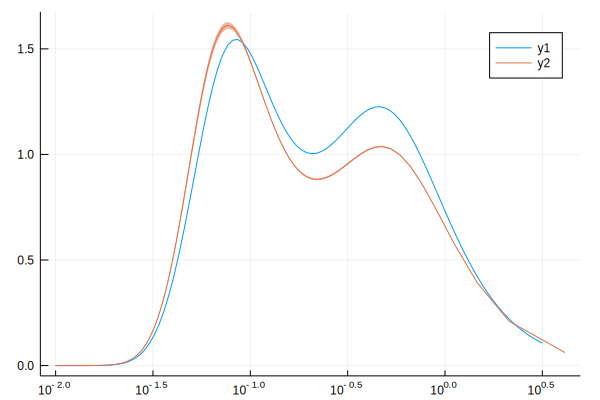

In [20]:
Nsample = 1000
data = [collect(mTPQ(H, l, N, D)) for i in 1 : Nsample]
m = mean(data)
s = stdm(data, m) / sqrt(Nsample)
cv = collect(Iterators.partition(m, 2))
eb = collect(Iterators.partition(s, 2))
plot!(map(x -> 1 / x[1], cv), map(x -> x[1] ^ 2 * x[2], cv), ribbon = map(x -> x[1][1] ^ 2 * x[2][2], zip(cv, eb)); xscale = :log10)

Be careful! TPQ state never agrees with an exact value in the finite system at high temperature!!! This is because TPQ state uses typicality of the quantum **many-body** systems, which is only exact in the thermodynamic limit. However, even if we consider such finite-size effects, TPQ states are doing well especially at low temperature. You can see how good TPQ is by `yscale = :log10` option.

